In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [7]:
#Train
#1
chunks =  [train_img[:, :14, :14], train_img[:, 14:, :14], train_img[:, :14, 14:], train_img[:, 14:, 14:]]

In [10]:
#2
chunks_final = np.zeros((len(train_img), 1))

for i in range(len(chunks)):
    chunks_sobel_x = np.zeros_like(chunks[i] )
    chunks_sobel_y = np.zeros_like(chunks[i] )
    for m in range(len(chunks[i])):
        chunks_sobel_x[m] = cv2.Sobel(chunks[i][m], cv2.CV_64F, dx=1, dy=0, ksize=3)
        chunks_sobel_y[m] = cv2.Sobel(chunks[i][m], cv2.CV_64F, dx=0, dy=1, ksize=3)
    chunks_g, chunks_theta = cv2.cartToPolar(chunks_sobel_x, chunks_sobel_y)      #3
    
    chunks_hist = np.zeros((len(chunks[i]), 16))   #4
    for x in range(len(chunks[i])):
        hist, borders = np.histogram(chunks_theta[x],
                                     bins=16,
                                     range=(0., 2. * np.pi),
                                     weights=chunks_g[x])
        chunks_hist[x] = hist
    chunks_final = np.hstack((chunks_final, chunks_hist))

chunks_final = chunks_final[:, 1:] #5

In [11]:
#Test
#1
chunks_tst =  [test_img[:, :14, :14], test_img[:, 14:, :14], test_img[:, :14, 14:], test_img[:, 14:, 14:]]

In [13]:
#2
chunks_final_tst = np.zeros((len(test_img), 1))

for i in range(len(chunks_tst)):
    chunks_sobel_x = np.zeros_like(chunks_tst[i] )
    chunks_sobel_y = np.zeros_like(chunks_tst[i] )
    for m in range(len(chunks_tst[i])):
        chunks_sobel_x[m] = cv2.Sobel(chunks_tst[i][m], cv2.CV_64F, dx=1, dy=0, ksize=3)
        chunks_sobel_y[m] = cv2.Sobel(chunks_tst[i][m], cv2.CV_64F, dx=0, dy=1, ksize=3)
    chunks_g, chunks_theta = cv2.cartToPolar(chunks_sobel_x, chunks_sobel_y)      #3
    
    chunks_hist = np.zeros((len(chunks_tst[i]), 16))
    for x in range(len(chunks_tst[i])):
        hist, borders = np.histogram(chunks_theta[x],
                                     bins=16,
                                     range=(0., 2. * np.pi),
                                     weights=chunks_g[x])
        chunks_hist[x] = hist
    chunks_final_tst = np.hstack((chunks_final_tst, chunks_hist))

chunks_final_tst = chunks_final_tst[:, 1:]

In [14]:
# нормализация методом из opencv
train_zero = np.zeros((42000, 64))
train_norm = cv2.normalize(chunks_final, train_zero)
test_norm = cv2.normalize(chunks_final_tst, train_zero)

## Разбиваем выборку на обучение и валидацию

In [15]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_norm, test_size=0.2, random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [16]:
centroids = np.zeros((10, train_norm.shape[1]), dtype=np.float32)

In [17]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [18]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [19]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.836785714286


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.93      0.91      0.92       816
        1.0       0.88      0.99      0.93       909
        2.0       0.86      0.85      0.86       846
        3.0       0.81      0.81      0.81       937
        4.0       0.95      0.79      0.86       839
        5.0       0.89      0.85      0.87       702
        6.0       0.86      0.89      0.87       785
        7.0       0.91      0.73      0.81       893
        8.0       0.66      0.79      0.72       835
        9.0       0.72      0.77      0.74       838

avg / total       0.84      0.84      0.84      8400



In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[741   3  10  11   8   3  13   1  20   6]
 [  0 896   2   0   1   0   1   0   5   4]
 [  4  12 721  53   2   2   8   6  27  11]
 [  3   2  33 760   0  38   4  19  34  44]
 [  0  24   8   3 666   0  43   2  37  56]
 [  0   1   1  53   1 594  12   5  22  13]
 [ 21  16   1   0   3   3 699   0  42   0]
 [  1  30  36  21   1   0   1 649  64  90]
 [ 19  21  20  19   9  23  31   8 658  27]
 [ 11  17   4  21  10   7   3  27  93 645]]


## Предсказания на тестовых данных

In [22]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_norm[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

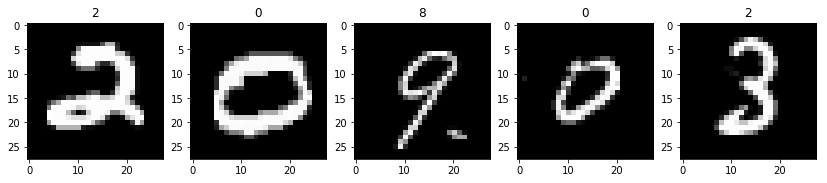

In [23]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [24]:
with open('submit_5.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

оценка на kaggle: 0.8352